# Analisis Penjualan PT. ***   
analisis mengunakan data yang berasal dari E-tax invoice (local) mengunakan export ke csv.
tujuan analisis untuk menampilkan data penjualan perbulan. 

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plot
import sys
import os


# daftar file dalam ".csv"
list_filepath = []
for directory, _, files in os.walk("data/big"):
    for file_ in files:
        if file_.endswith(".csv"):
            file_path = os.path.join(directory, file_)
            list_filepath.append(file_path)

# daftar data frame
list_df = [pd.read_csv(file_) for file_ in list_filepath]
print("Banyaknya jumlah dataframe :",len(list_df))

# menggabungkan dengan mengunakan concat
df = pd.concat(list_df)
print("Banyaknya jumlah baris dan kolom :", df.shape)

Banyaknya jumlah dataframe : 13
Banyaknya jumlah baris dan kolom : (281680, 19)


Banyaknya Jumlah Dataframe yang digunakan sebanyak 13 unit. hal ini di karenakan dalam setiap mengekspor data ke dalam file csv hanya sebanyak 5000 Faktur per file.

dataframe-dataframe tersebut lalu digabung menjadi satu dataframe. berisi 281.680 baris, dan 19 kolom.

### Membersihkan Data

mencari data penjualan barang dagangan, maka dataframe harus dibersikan telebih dahulu.

skema yang di dapat ketika mengekspor data e-tax kedalam file csv adalah sebagai berikut:
* **Baris**, untuk setiap barisnya mempunyai element sebagai berikut:
    * **FK** adalah header yang berisi data untuk setiap transaksi
    * **LT** adalah baris yang berisi data mengenai detail lawan transaksi 
    * **FAPR** adalah baris yang berisi data mengenai detail pembuat transaksi
    * **OF** adalah baris yang berisi data mengenai detail objek yang ditransaksikan.

* **Kolom**
 untuk kolom bisa dilihat dibawah ini.

mencari data penjualan maka hanya perlu mengunakan data baris FK yang berisi rangkuman informasi transaksi. 

In [2]:
# Hanya mengunakan data pada baris Fk saja.
df = df[(df['FK'] == "FK")]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 36247 entries, 2 to 35733
Data columns (total 19 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   FK                      36247 non-null  object 
 1   KD_JENIS_TRANSAKSI      36247 non-null  object 
 2   FG_PENGGANTI            36247 non-null  object 
 3   NOMOR_FAKTUR            36247 non-null  object 
 4   MASA_PAJAK              36247 non-null  object 
 5   TAHUN_PAJAK             36247 non-null  object 
 6   TANGGAL_FAKTUR          36247 non-null  object 
 7   NPWP                    36247 non-null  object 
 8   NAMA                    36247 non-null  object 
 9   ALAMAT_LENGKAP          36247 non-null  object 
 10  JUMLAH_DPP              36247 non-null  object 
 11  JUMLAH_PPN              36247 non-null  object 
 12  JUMLAH_PPNBM            36247 non-null  object 
 13  ID_KETERANGAN_TAMBAHAN  1 non-null      object 
 14  FG_UANG_MUKA            36247 non-null

 menghapus kolom-kolom yang tidak dipakai, dan berisi Nan


In [3]:
# Berikut kolom-kolom yang tidak dipakai untuk menampilkan jumlah penjualan barang dagangan
unused_columns = ["FK", "ALAMAT_LENGKAP", "JUMLAH_PPNBM", 
                "ID_KETERANGAN_TAMBAHAN","FG_UANG_MUKA", "UANG_MUKA_DPP",
                "UANG_MUKA_PPN", "UANG_MUKA_PPNBM"]

df = df.drop(unused_columns, axis=1) # axis = 1 for column define

#### Memfilter faktur Normal

dalam mengupload faktur kedalam database terkadang sang admin melakukan kesalahan dalam menginput kode jenis transaksi yang sesuai dengan jenis transaksi yang dilakukan perusahaan. 
PT. *** mengunakan kode "01" untuk setiap transaksi yang dibuatnya. maka untuk transaksi dengan kode yang lain tidak digunakan

In [4]:
# Memfilter hanya faktur normal (faktur denangan kode 010 dan 011)
df = df[df["KD_JENIS_TRANSAKSI"] == '01']

#### Menghapus kolom

Kolom "KD_JENIS_TRANSAKSI" tidak digunakan lagi untuk seterusnya maka kolom tersebut dihapus untuk meminimalisasi pengunaan memory.

untuk kolom "NAMA" yang berisi data yang sensitif perusahaaan PT.*** maka ini dihapus. 

In [5]:
# Menghapus kolom yang tidak terpakai
df = df.drop(["KD_JENIS_TRANSAKSI", "NAMA"], axis=1)

# Mereset index 
df.reset_index(drop=True, inplace=True)

### Mengubah data tipe 

berikut kolom yang data tipenya akan diubah:

* FG_PENGGANTI menjadi int, 0 (nol) untuk Faktur normal, 1 untuk faktur normal-pengganti.
* JUMLAH_DPP menjadi int/float
* JUMLAH_PPN menjadi int/float
* MASA_PAJAK menjadi int
* TAHUN_PAJAK menjadi int

In [6]:
df[["FG_PENGGANTI","JUMLAH_DPP","JUMLAH_PPN"]] = df[["FG_PENGGANTI","JUMLAH_DPP","JUMLAH_PPN"]].apply(pd.to_numeric)

df = df.astype({"TAHUN_PAJAK":int, "MASA_PAJAK":int})
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36245 entries, 0 to 36244
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   FG_PENGGANTI    36245 non-null  int64  
 1   NOMOR_FAKTUR    36245 non-null  object 
 2   MASA_PAJAK      36245 non-null  int64  
 3   TAHUN_PAJAK     36245 non-null  int64  
 4   TANGGAL_FAKTUR  36245 non-null  object 
 5   NPWP            36245 non-null  object 
 6   JUMLAH_DPP      36245 non-null  float64
 7   JUMLAH_PPN      36245 non-null  float64
 8   REFERENSI       36242 non-null  object 
dtypes: float64(2), int64(3), object(4)
memory usage: 2.5+ MB


### filter data hanya penjualan barang dagangan bukan jasa
dalam E-tax transaksi dapat berupa penjualan barang (barang dagangan) atau jasa dan asset.
Perusahaan PT.*** mengunakan refrensi "INV..." untuk penjualan barang dagang, sedangkan jasa dan asset, mengunakan no surat atau tidak mencantumkan refrensi.

In [7]:
# Menfilter Kolom refrensi untuk penjualan barang dagang

# Fungsi boolean jika refrensi INV
def inv(x):
    return str(x).startswith("INV")
    
df["IS_INV"] = df["REFERENSI"].apply(inv) # memasukan ke dalam kolom baru

fk = df[df["IS_INV"] == True]     # mengambil data INV saja
fk.head(3)

,FG_PENGGANTI,NOMOR_FAKTUR,MASA_PAJAK,TAHUN_PAJAK,TANGGAL_FAKTUR,NPWP,JUMLAH_DPP,JUMLAH_PPN,REFERENSI,IS_INV
0,0,0031861313000,8,2018,01/08/2018,025765504322000,1330909.0,133091.0,INV.NO.INVL18-00025899 NO.SO.PFIL18-00027347,True
1,0,0031861313001,8,2018,01/08/2018,018468918051000,1800218.0,180022.0,INV.NO.INVL18-00025900 NO.SO.PFIL18-00027348,True
2,0,0031861313002,8,2018,01/08/2018,013362389054000,2631847.0,263185.0,INV.NO.INVL18-00025901 NO.SO.PFIL18-00027349,True


## Mengelopokan Data

### Faktur normal dan Faktur normal-pengganti

saat melaporkan faktur di E-tax, faktur berstatus normal (FG_PENGGANTI = 0). namun untuk terkadang faktur yang sudah diaproval tidak sesuai dengan transaksi. maka untuk membetulkan faktur tersebut agar sesuai dengan transaksi dibuatlah faktur normal-pengganti (FG_PENGGANTI = 1).  
hal ini menyebabkan duplikat atau (Garbage data)lebih tepatnya sebuah data yang masih tersisa.
untuk mencari faktur yang benar maka perlu dihapus faktur yang lama.

In [8]:
# Mampilkan fata faktur normal dan normal pengganti
fg_pengganti = fk[fk.duplicated(["NOMOR_FAKTUR"])]

list_fg = fg_pengganti["NOMOR_FAKTUR"].to_list()

def fk_pengganti(no, fg):
    if no in list_fg and fg == 0:
        return 1
    else:
        return 0
    

fk["TO_DEL"] = fk.apply(lambda x : fk_pengganti(x["NOMOR_FAKTUR"], x["FG_PENGGANTI"]), axis=1)
fk = fk[fk["TO_DEL"] == 0]

## Penjualan Per Bulan / Masa


In [9]:
sales = fk.groupby("MASA_PAJAK")["JUMLAH_DPP","JUMLAH_PPN"].sum()

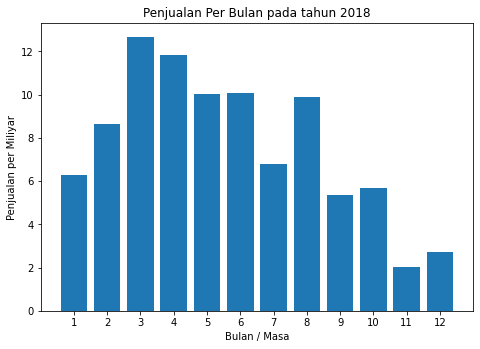

In [10]:
ammount = [dpp + ppn for dpp, ppn in zip(sales["JUMLAH_DPP"], sales["JUMLAH_PPN"])]
# total penjualan yang di skala menjadi milyar
ammount_m = [i / (10**9) for i in ammount]
lbl = sales.index.to_list()

#print("Total penjualan setahun {:,}".format(sum(ammount)))

def plot_sales():
    fig = plot.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.bar(lbl, ammount_m)
    plot.xlabel("Bulan / Masa")
    plot.ylabel("Penjualan per Miliyar")
    plot.title("Penjualan Per Bulan pada tahun 2018")
    plot.xticks(lbl)
    plot.show()

plot_sales()

Diatas adalah grafik batang yang menunjukan penjulan perbulan selama tahun 2018. grafik mengunakan skala y axis satuan miliyar.

## Penjualan berdasarkan pembeli

### 1. pembeli pkp dan non pkp

pembeli membeli produk PT.*** dapat mencantumkan NPWP dan juga tanpa mencantumkan NPWP.

ada hal yang dominan dari pemisahan ini:
* **Pembeli berNPWP (PKP)** lebih di dominasi oleh toko-toko besar, retail, super market dan lain-lain. tidak menutup kemungkinan bahwa pembeli beNPWP adalah retail kecil, seperti koperasi perusahaan.
* **Pembeli tidak berNPWP (non PKP)** didominasi oleh toko-toko kelontong, petak pedagang pasar, dsb.

In [11]:
# Normalisasi data tipe pada kolom NPWP

def non_pkp(x):
    nonpkp = "0"*15
    if x=='0' or x == nonpkp or x == 0.0:
        return nonpkp
    else:
        return str(x)

fk["NPWP"] = fk["NPWP"].apply(non_pkp)

In [12]:
# pkp atau non pkp
# mengembalikan Non Pkp jika NPWP = 000000000000000
def is_pkp(x):
    nonpkp = "0"*15
    if x=='0' or x == nonpkp or x == 0.0:
        return "NON-PKP"
    else:
        return "PKP"

fk["IS_PKP"] = fk["NPWP"].apply(is_pkp)

In [13]:
pkp = fk.groupby("IS_PKP")["JUMLAH_DPP","JUMLAH_PPN"].sum()

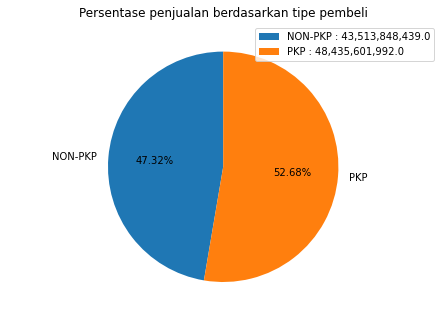

In [14]:
ammount = [dpp + ppn for dpp, ppn in zip(pkp["JUMLAH_DPP"], pkp["JUMLAH_PPN"])]
ixlbl = pkp.index.to_list()

def plot_share_pkp():
    s_lbl = ["{} : {:,}".format(lbl,t) for lbl, t in zip(ixlbl, ammount)]
    fig = plot.figure()
    ax = fig.add_axes([0,0,1,1])
    ax.axis("equal")
    patch = ax.pie(ammount, labels=pkp.index.to_list(), autopct='%1.2f%%', startangle=90)
    plot.legend(patch[0], s_lbl)
    plot.title("Persentase penjualan berdasarkan tipe pembeli")
    plot.show()

plot_share_pkp()


berdasarkan persentase grafik diatas bahwa penjualan produk memiliki proporsi yang seimbang

## 2. Penjualan kepada pelanggan

Menampilkan data penjualan produk kepada pelanggan yang memiliki NPWP.

In [15]:
buyer = fk.groupby("NPWP", as_index=False)["JUMLAH_DPP","JUMLAH_PPN"].sum()
# Menghapus data row non pkp
buyer = buyer.drop(0)

# membuat nama alias
name = [f"PT{i}" for i in range(1, buyer.shape[0] + 1)]
buyer["NAMA"] = name

In [16]:
# membuat 10 besar total dpp
def ten_max(list_x):
    final_list = []
    for i in range(0, 10):
        max1 = 0
        for j in range(len(list_x)):
            if list_x[j] > max1:
                max1 = list_x[j]
                #print(list_x[k])
        list_x.remove(max1)
        final_list.append(max1)
    return final_list

bulist = buyer["JUMLAH_DPP"].to_list()[:]
max10 = ten_max(bulist)

In [17]:
def is_ten_max(x, name):
    if x >= max10[-1]:
        return name
    else:
        return "DLL"

buyer["NEW_NAME"] = buyer.apply(lambda x: is_ten_max(x["JUMLAH_DPP"], x["NAMA"]), axis=1)
new_buyer = buyer.groupby("NEW_NAME", as_index=False)["JUMLAH_DPP","JUMLAH_PPN"].sum()

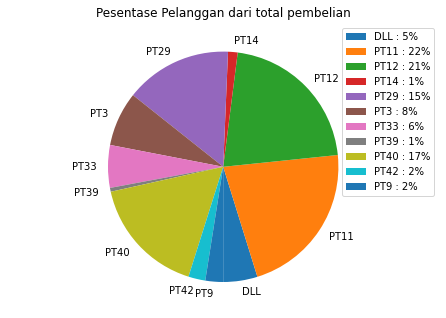

In [18]:
ammount = [dpp + ppn for dpp, ppn in zip(new_buyer["JUMLAH_DPP"],new_buyer["JUMLAH_PPN"])]
ammount_m = [i / (10**9) for i in ammount]
lbl = new_buyer["NEW_NAME"].to_list()[:]

totals = sum(ammount)
percentace = [round((i * 100) / totals) for i in ammount]

def plot_per_buyer():
    s_lbl = [f"{l} : {i}%" for l, i in zip(lbl, percentace)]
    fig = plot.figure()
    ax = fig.add_axes([0,0,1,1,])
    ax.axis("equal")
    patch, txt = ax.pie(ammount_m, labels=lbl, startangle=-90)
    plot.title("Pesentase Pelanggan dari total pembelian")
    plot.legend(patch, s_lbl, loc='best')
    plot.show()

plot_per_buyer()

terdapat 4 perusahaan dominan yang membeli Produk PT.*** diatas 10 persen total penjualan pada pembeli berNPWP:  

1. PT11 sebesar 22%
2. PT12 sebesar 21%
3. PT40 sebesar 17%
4. PT29 sebesar 15%

Demikianlah Laporan mengenai Penjualan Produk PT.***. Terima kasih atas perhatiannya.